In [12]:
import tensorflow as tf

import tensorflow_probability as tfp
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

## Load the dataset

In [13]:
# load the features and labels (subtract 1 as the labels aren't indexed from 0)

# load the features and labels
xtest = np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/test/X_test.txt')
ytest = np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/test/y_test.txt') - 1

xtrain = np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/train/X_train.txt')
ytrain = np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/train/y_train.txt')-1

# load the x,y,z body accelerations test data
xx=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/test/Inertial Signals/body_acc_x_test.txt')
yy=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/test/Inertial Signals/body_acc_y_test.txt')
zz=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/test/Inertial Signals/body_acc_z_test.txt')

In [3]:
np.unique(ytest)

array([0., 1., 2., 3., 4., 5.])

## Set the lables

In [4]:
WALKING=0
WALKING_UPSTAIRS=1
WALKING_DOWNSTAIRS=2
SITTING=3
STANDING=4
LAYING=5

## Plotting the raw data

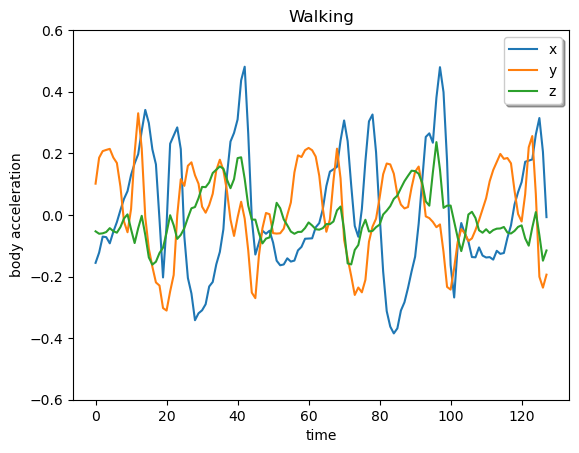

In [11]:
random_ts = np.random.choice(np.where(ytest==WALKING)[0])
plt.plot(xx[random_ts])
plt.plot(yy[random_ts])
plt.plot(zz[random_ts])
plt.legend(('x', 'y', 'z'),loc='upper right', shadow=True)
plt.title('Walking')
plt.xlabel('time')
plt.ylabel('body acceleration')
plt.ylim(-0.6,0.6)

plt.show()

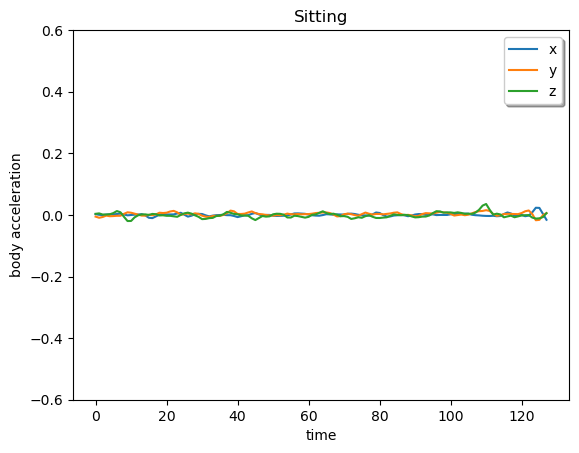

In [12]:
random_ts = np.random.choice(np.where(ytest==SITTING)[0])
plt.plot(xx[random_ts])
plt.plot(yy[random_ts])
plt.plot(zz[random_ts])
plt.legend(('x', 'y', 'z'),loc='upper right', shadow=True)
plt.title('Sitting')
plt.xlabel('time')
plt.ylabel('body acceleration')
plt.ylim(-0.6,0.6)
plt.show()

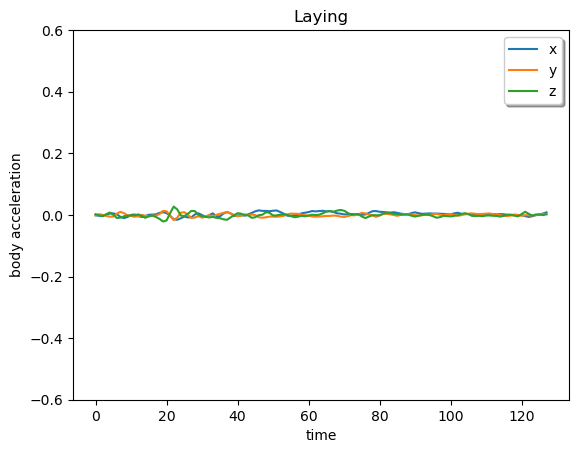

In [13]:
random_ts = np.random.choice(np.where(ytest==LAYING)[0])
plt.plot(xx[random_ts])
plt.plot(yy[random_ts])
plt.plot(zz[random_ts])
plt.legend(('x', 'y', 'z'),loc='upper right', shadow=True)
plt.title('Laying')
plt.xlabel('time')
plt.ylabel('body acceleration')
plt.ylim(-0.6,0.6)

plt.show()

## Handcrafted features

In [14]:
flist = np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/features.txt',dtype='S')
for i in range(30):
    print(flist[i])

[b'1' b'tBodyAcc-mean()-X']
[b'2' b'tBodyAcc-mean()-Y']
[b'3' b'tBodyAcc-mean()-Z']
[b'4' b'tBodyAcc-std()-X']
[b'5' b'tBodyAcc-std()-Y']
[b'6' b'tBodyAcc-std()-Z']
[b'7' b'tBodyAcc-mad()-X']
[b'8' b'tBodyAcc-mad()-Y']
[b'9' b'tBodyAcc-mad()-Z']
[b'10' b'tBodyAcc-max()-X']
[b'11' b'tBodyAcc-max()-Y']
[b'12' b'tBodyAcc-max()-Z']
[b'13' b'tBodyAcc-min()-X']
[b'14' b'tBodyAcc-min()-Y']
[b'15' b'tBodyAcc-min()-Z']
[b'16' b'tBodyAcc-sma()']
[b'17' b'tBodyAcc-energy()-X']
[b'18' b'tBodyAcc-energy()-Y']
[b'19' b'tBodyAcc-energy()-Z']
[b'20' b'tBodyAcc-iqr()-X']
[b'21' b'tBodyAcc-iqr()-Y']
[b'22' b'tBodyAcc-iqr()-Z']
[b'23' b'tBodyAcc-entropy()-X']
[b'24' b'tBodyAcc-entropy()-Y']
[b'25' b'tBodyAcc-entropy()-Z']
[b'26' b'tBodyAcc-arCoeff()-X,1']
[b'27' b'tBodyAcc-arCoeff()-X,2']
[b'28' b'tBodyAcc-arCoeff()-X,3']
[b'29' b'tBodyAcc-arCoeff()-X,4']
[b'30' b'tBodyAcc-arCoeff()-Y,1']


In [15]:
ytrain.shape


(7352,)

## Training a classifier on the features

In [16]:
# Convert your input data to a tensor so that you can pass it into your classifier
xtrain = tf.convert_to_tensor(xtrain, tf.float32)

# Convert the classes to categorical variables
ytrain1h = tf.cast(tf.keras.utils.to_categorical(ytrain), tf.float32)

2023-07-03 17:06:42.182971: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 17:06:42.741185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10794 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


In [17]:
ytrain1h.shape

TensorShape([7352, 6])

## Set up the loss and gradient updates

In [18]:

# Define the logistic regression model

W = tf.Variable(tf.zeros([561, 6]), tf.float32)
b = tf.Variable(tf.zeros([6]), tf.float32)

def predict(x):
  return tf.nn.softmax(tf.add(tf.matmul(x, W), b))


# categorical cross entropy loss
def loss(y_pred, y_true):
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)  #clip by value ensure that we don't get our prediciton too low 
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred),axis=1))




# Define the training function to compute prediction, loss and gradient updates
@tf.function
def train(x, y):
    with tf.GradientTape() as tape:
        predicted = predict(x)   
        current_loss = loss(predicted,y)
        gradients = tape.gradient(current_loss, [W, b])

    optimizer.apply_gradients(zip(gradients, [W, b]))
    return current_loss

## Run the training

  0%|          | 0/10000 [00:00<?, ?it/s]

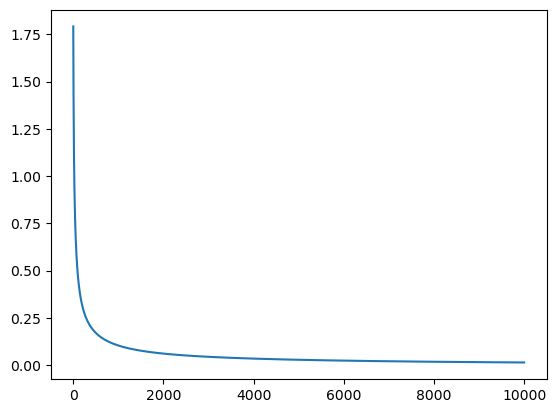

In [19]:
n_iters = 10000

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)


loss_history=np.zeros(n_iters)
# Training the classifier for 1000 epochs
epochs = range(n_iters)
for epoch in tqdm(epochs):

    training_loss = train(xtrain, ytrain1h)
    loss_history[epoch]=training_loss.numpy()
    
plt.plot(loss_history)
plt.show()

## Accuracy measures

In [20]:

print("Epoch: %i, loss: %f" % (epoch, training_loss))

# Training accuracy
y_prob = predict(xtrain)
print('\nCurent Output vector shape (Training):', y_prob.shape)
print('Training Label shape:', ytrain.shape)
y_pred = np.argmax(y_prob,axis=-1)
print('Training accuracy: ', np.sum(y_pred==ytrain)/len(ytrain))

# Testing accuracy
xtest = tf.convert_to_tensor(xtest, tf.float32)
y_prob = predict(xtest)
print('\nCurent Output vector shape (Testing):', y_prob.shape)
print('Training Label shape:', ytest.shape)
y_pred = np.argmax(y_prob,axis=-1)
print('Testing accuracy: ', np.sum(y_pred==ytest)/len(ytest))

Epoch: 9999, loss: 0.014378

Curent Output vector shape (Training): (7352, 6)
Training Label shape: (7352,)
Training accuracy:  0.9955114254624592

Curent Output vector shape (Testing): (2947, 6)
Training Label shape: (2947,)
Testing accuracy:  0.9572446555819477


In [21]:
#very high accuracy for training and high for testing

## Fitting a model with tensorflow probability

In [22]:
xtrain_s = xtrain[:,22:25].numpy()   #we use entropy measurements as you can clearly see the difference between static and dynamic classes like walking and sitting


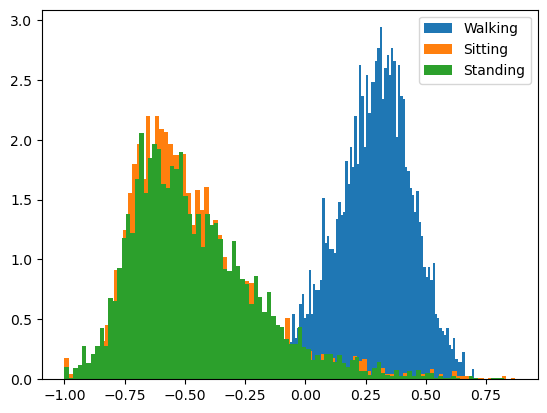

In [24]:

plt.hist(xtrain_s[ytrain==WALKING].flatten(),bins=100,density=True,label='Walking')
plt.hist(xtrain_s[ytrain==SITTING].flatten(),bins=100,density=True, label = 'Sitting')
plt.hist(xtrain_s[ytrain==STANDING].flatten(),bins=100,density=True, label ='Standing')
plt.legend()
plt.show()
    

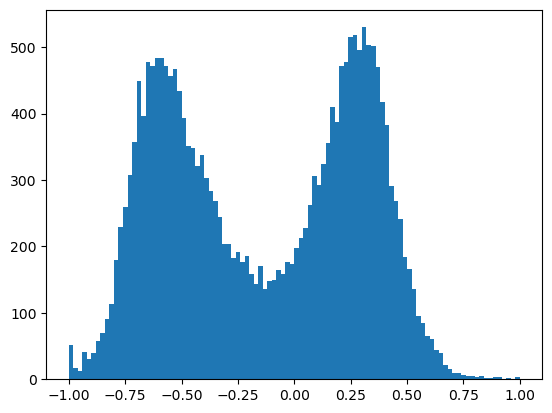

In [26]:
#together
x = xtrain_s.flatten()
plt.hist(x,bins=100)

plt.show()
#We eill treat as gaussian mixture model
#learning the paramters of the model that maximizes the likelihood of the data

In [ ]:
?tfp.distributions.Mixture     # combination of different probability distributions

In [29]:
?tfp.distributions.MixtureSameFamily

Init signature: tfp.distributions.MixtureSameFamily(*args, **kwargs)
Docstring:     
Mixture (same-family) distribution.

  The `MixtureSameFamily` distribution implements a (batch of) mixture
  distribution where all components are from different parameterizations of the
  same distribution type. It is parameterized by a `Categorical` 'selecting
  distribution' (over `k` components) and a components distribution, i.e., a
  `Distribution` with a rightmost batch shape (equal to `[k]`) which indexes
  each (batch of) component.

  #### Examples

  ```python
  tfd = tfp.distributions

  ### Create a mixture of two scalar Gaussians:

  gm = tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(
          probs=[0.3, 0.7]),
      components_distribution=tfd.Normal(
        loc=[-1., 1],       # One for each component.
        scale=[0.1, 0.5]))  # And same here.

  gm.mean()
  # ==> 0.4

  gm.variance()
  # ==> 1.018

  # Plot PDF.
  x = np.linspace(-2., 3., int(1e4), dtype=np.f

## Set up a Gaussian mixture model for the data

In [27]:
# very similar to how we setup ip a loss function
# we use the negative of the log likelihood because our iptimizer tries to minimise the loss (reduce loss ---> maximise likelihood)

observations = tf.convert_to_tensor(x,dtype=tf.float32)

def mixture_distribution(m,means,stddevs):
    m = tf.math.sigmoid(m)      #scale the value between 0 and 1
    stddevs = tf.math.softplus(stddevs)  # this has to be positive
    gm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(probs=[m,1-m]), 
                                             components_distribution=tfp.distributions.Normal(loc=means, scale=stddevs)) 
    return gm
    
def log_likelihood_mixture(m,means,stddevs):  

    gm = mixture_distribution(m,means,stddevs)
    # return a single log likelihood for all the observations
    total_log_likelihood = tf.reduce_sum(gm.log_prob(observations))

    return total_log_likelihood

In [28]:

stddevs = tf.Variable([-2.,-2.])   #we start with standard deviation quite small
means = tf.Variable([0.,0.])
m = tf.Variable(0.5)  #50-50 chance of being in each mixture

log_likelihood_mixture(m,means,stddevs)

<tf.Tensor: shape=(), dtype=float32, numpy=-112893.06>

## Train using standard tf operations

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 9999, loss: 8003.472656


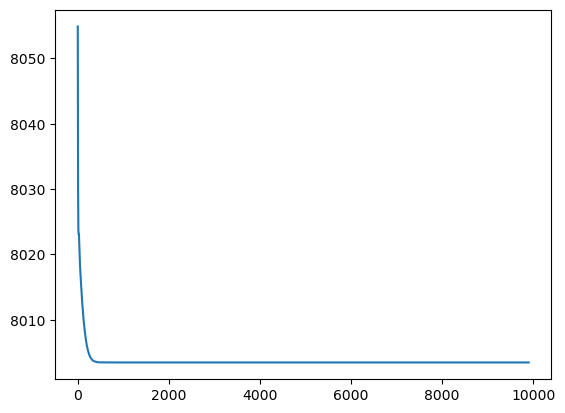

In [29]:

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)


@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = -log_likelihood_mixture(m,means,stddevs)   #we take the negative
        # Gradient computation
        gradients = tape.gradient(loss, [m,means,stddevs])
    # parameter update
    optimizer.apply_gradients(zip(gradients, [m,means,stddevs]))
    return loss


n_iters = 10000

loss_history=np.zeros(n_iters)
epochs = range(n_iters)
for epoch in tqdm(epochs):

    training_loss = train_step()
    loss_history[epoch]=training_loss.numpy()
print("Epoch: %i, loss: %f" % (epoch, training_loss))

plt.plot(loss_history[100:])
plt.show()

In [30]:
print(means.numpy())
print(tf.math.softplus(stddevs).numpy())
print(tf.math.sigmoid(m).numpy())

[-0.52659124  0.24754936]
[0.18455124 0.18320237]
0.49410674


## Plot the fitted distributions

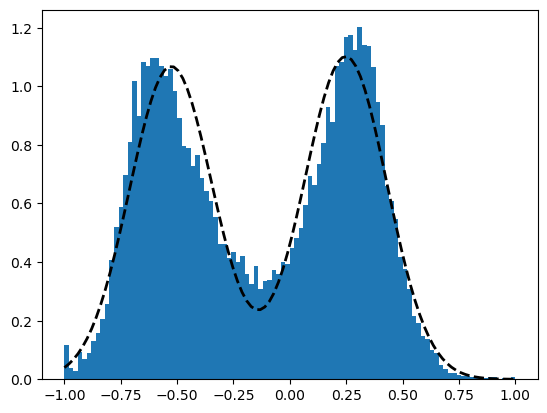

In [31]:
# this will result to be compare quite well with the real data. Probably the raw data is not normally distributed
gm = mixture_distribution(m,means,stddevs)


plt.hist(x,bins=100,density=True)


plt.plot(np.linspace(x.min(),x.max(),100),gm.prob(np.linspace(x.min(),x.max(),100)),lw=2,c='k',ls='--')
plt.show()


In [32]:
gm.sample()

<tf.Tensor: shape=(), dtype=float32, numpy=-0.48925558>

In [33]:
gm.prob(2.0)

<tf.Tensor: shape=(), dtype=float32, numpy=1.488282e-20>

In [43]:
gm.log_prob(2.0)   #log probability of value 2. We ue the log for numerical reason, so we can add the numbers together.

<tf.Tensor: shape=(), dtype=float32, numpy=-45.65408>

In [45]:
?tfp.distributions

Type:        module
String form: <module 'tensorflow_probability.python.distributions' from '/opt/conda/lib/python3.8/site-packages/tensorflow_probability/python/distributions/__init__.py'>
File:        /opt/conda/lib/python3.8/site-packages/tensorflow_probability/python/distributions/__init__.py
Docstring:   Statistical distributions.